In [128]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
import numpy.random as rand
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Sensing/'
num_cores = -1 #number of cores for parallelization

# System parameters for spin chain
J = 1.0         # +ve is Ferromagnet [Hamiltonian as defined Mishra, Bayat, PRL 127, 080504 (2021)]
gamma = 0.8   # J(1+gamma)XX + J(1-gamma)YY (ignoring other factors, see paper or notes for defn.)
sites = 3     # system size, for ground state pick even N as odd N is not verified (pi or -pi mode becomes special)
h1_amp = 1.0    # amplitude of the drive for periodic transverse field
h1_period = 1.0 # period of the drive for periodic transverse field
h0 = 0.5      # static transverse field
stroboscopic_times = 10

method = 'RK45'  # integration method #'RK45' (4th order), 'DOP853' (8th order), 'BDF'
rtol = 10**(-12) # relative tolerance of integration scheme
atol = 10**(-12) # absolute tolerance of integration scheme
dt = 0.01        # return results with this step (does not affect integration accuracy)

# Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Boundary conditions
boundary_conditions = 'PBC' # USE PBC ONLY FOR NOW (which restricts valid parity for comparison with TFIM)
# 'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions
# The boundary conditions must reflect the fermion parity in the initial conditions (see above).
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.


Initial Conditions and define Nambu Hamiltonian

In [129]:
# Build correlation matrices for initial condition
obs, Dag_obs = methods.initialize_state(sites, gamma, J, h0, 0, boundary_conditions, initial_state)

# Initial Nambu correlation matrix
Corr_mat = copy.copy(obs)
Dag_mat = copy.copy(Dag_obs)

# Note the unintuition definition. Is there an error in the way the Nambu correlator is defined? Clearly results work but seems strange.
Nambu_Correlator = np.zeros([2*sites,2*sites],dtype = complex) # note the way the matrix is defined. <c_i† c_j> is lower right block (not top left!)
Nambu_Correlator[0:sites, 0:sites]   = np.eye(sites) - Corr_mat.T      # <c_i c_j†>
Nambu_Correlator[0:sites, sites:]    = Dag_mat.T                      # <c_i c_j>
Nambu_Correlator[sites:, 0:sites]    = Dag_mat.conj()                 # <c_i† c_j†>
Nambu_Correlator[sites:, sites:]     = Corr_mat                        # <c_i† c_j>

# Definition of nambu Hamiltonian
def Hnambu(J, gamma, h, sites):
    size = 2 * sites
    Hnambu = np.zeros((size, size), dtype=complex)

    for jj in range(size):
        for kk in range(size):
            if jj < sites and kk < sites:
                # Upper-left block: kinetic terms with PBC
                if jj == (kk + 1) % sites or jj == (kk - 1) % sites:
                    Hnambu[jj, kk] = -J / 2.0
                if jj == kk:
                    Hnambu[jj, kk] = -h #/ 4.0

            elif jj >= sites and kk >= sites:
                # Lower-right block: diagonal with h
                if jj == kk:
                    Hnambu[jj, kk] = h #/ 4.0

                if jj == (kk + 1) % sites + sites or jj == (kk - 1) % sites + sites:
                    Hnambu[jj, kk] = J / 2.0

            elif jj < sites and kk >= sites:


            #     # Upper-right block: pairing terms

                if kk == (jj+1) % sites + sites:

                    Hnambu[jj, kk] = -J * gamma / 2.0 
                    Hnambu[kk - sites, jj + sites] = J * gamma / 2.0 

            elif jj >= sites and kk < sites:
                # Lower-left block: pairing terms (Hermitian conjugate)
                if jj == (kk + 1) % sites + sites:

                    Hnambu[jj, kk] = -J * gamma / 2.0
                    Hnambu[kk + sites, jj - sites] = J * gamma / 2.0

    return Hnambu
 
# Definition of nambu Hamiltonian
# In this case the functions takes a vector of J values and h values (such as disorder)
def Hnambu_disorder(Jvec, gamma, hvec, sites):
    size = 2 * sites
    Hnambu = np.zeros((size, size), dtype=complex)

    for jj in range(size):
        for kk in range(size):
            if jj < sites and kk < sites:
                # Upper-left block: kinetic terms with PBC
                if jj == (kk + 1) % sites or jj == (kk - 1) % sites:
                    if jj == (kk + 1) % sites:
                        Jhold = Jvec[jj-1]
                    else:
                        Jhold = Jvec[jj]
                    if jj < kk:
                        Hnambu[jj, kk] = -Jhold / 2.0
                    if jj > kk:
                        Hnambu[jj, kk] = -Jhold / 2.0
                if jj == kk:
                    Hnambu[jj, kk] = -hvec[jj] #/ 4.0

            elif jj >= sites and kk >= sites:
                # Lower-right block: diagonal with h
                if jj == kk:
                    Hnambu[jj, kk] = hvec[jj - sites] #/ 4.0

                if jj == (kk + 1) % sites + sites or jj == (kk - 1) % sites + sites:
                    if jj == (kk + 1) % sites + sites:
                        Jhold = Jvec[jj - sites - 1]
                    else:
                        Jhold = Jvec[jj - sites]

                    Hnambu[jj, kk] = Jhold  / 2.0

            elif jj < sites and kk >= sites: #XXX
            #     # Upper-right block: pairing terms

                if kk == (jj+1) % sites + sites:

                    Hnambu[jj, kk] = - Jvec[jj%sites] * gamma / 2.0 
                    Hnambu[kk - sites, jj + sites] = Jvec[jj%sites] * gamma / 2.0 

            elif jj >= sites and kk < sites:
                # Lower-left block: pairing terms (Hermitian conjugate)
                if jj == (kk + 1) % sites + sites:

                    Hnambu[jj, kk] = - Jvec[jj%sites] * gamma / 2.0
                    Hnambu[kk + sites, jj - sites] = Jvec[jj%sites] * gamma / 2.0

    return Hnambu

Perform integration over a period and construct floquet unitary

In [130]:
oneperiod_steps = int(h1_period/dt) # number of steps in one period, make sure this is integer.
times = oneperiod_steps

def system_rhs(t, y_flat, J, gamma, h0, h1, omega, sites):

    h_t = h0 + h1 * np.sin(omega * t)

    Ham_t = Hnambu(J,  gamma, h_t, sites)

    y = y_flat.reshape((2*sites, 2*sites))  # Reshape to match Ham

    # implement for extra accuracy
    yy = y.reshape((2*sites, 2*sites))
    Uu, _, Uv = np.linalg.svd(yy)
    y = Uu @ Uv  # Closest unitary matrix

    dydt = -1j * Ham_t @ y

    return dydt.flatten()
    
sol = solve_ivp(
    fun=lambda t, y: system_rhs(t, y, J, gamma, h0, h1_amp, 2 * np.pi / h1_period, sites),
    t_span=(0, dt * times),
    y0=np.identity(2 * sites,dtype=complex).flatten(),  # Flatten if system_rhs expects 1D array
    method=method,                        # e.g., 'RK45', 'DOP853', 'BDF'
    t_eval=dt * np.arange(0,times + 1),
    vectorized=False,
    atol=atol,
    rtol=rtol
)

# let us now compute the Floquet eigenvalues and eigenvectors (of the unitary matrix not the Floquet Hamiltonian)
UT =  sol.y[:,-1].reshape((2*sites, 2*sites)) #U_array[tt]  # Use the U_array instead of sol.y

w, v = lin.eig(UT)

# Calculate the nambu matrix explicitly over the first period (an additional check) for plotting against ED / direct integration
Nambu_T_mat = []
for tt in range(0,times+1):

    UT =  sol.y[:,tt].reshape((2*sites, 2*sites)) #U_array[tt]  # Use the U_array instead of sol.y

    Nambu_T = np.dot(UT, np.dot(Nambu_Correlator, np.conjugate(np.transpose(UT))))

    Nambu_T_mat += [Nambu_T]

Nambu_T_mat = np.asarray(Nambu_T_mat)




Calculate the stroboscopic evolution uin Floquet eigenbasis

In [131]:
# rotate into eigenbasis first, do time evolution, then rotate back

# Define and initialize
inv_v = np.linalg.inv(v)
Nambu_nT = []
Nambu_eigenbasis = np.dot(inv_v, Nambu_Correlator @ v)  # Rotate to eigenbasis

# Do stroboscopic evolution
for nn in range(0, stroboscopic_times+1):
    UTemp = np.diag(w**(nn))  
    Nambu_nT_diag = np.dot(UTemp, np.dot(Nambu_eigenbasis, np.conjugate(np.transpose(UTemp))))
    Nambu_nT +=  [np.dot(v, Nambu_nT_diag @ inv_v)] # rotate back and store the matrix in list

Nambu_nT = np.asarray(Nambu_nT) #convert list to array



In [132]:
####### CHECK AGAINST DIRECT INTEGRATION OF CORRELATORS (element by element)
# Initialize Time parameters 
method = 'RK45' # integration method #'RK45' (4th order), 'DOP853' (8th order), 'BDF'
rtol = 10**(-12) # relative tolerance of integration scheme
atol = 10**(-12) # absolute tolerance of integration scheme
#h1 = h1_amp*np.sin(2*np.pi/(h1_period)*dt*np.arange(0,oneperiod_steps+1)) # initialize periodic field, note + 1 time added here for RK4 and heun integration step endpoints
Corr_mat_list, Dag_mat_list, corr_diag = methods.integrator_matrices_eff(obs, Dag_obs, J, gamma, h0, h1_amp, 2 * np.pi / h1_period, stroboscopic_times * oneperiod_steps + 1, dt, sites, boundary_conditions, method, atol, rtol)

0:00:00.194421 End Simulation


# Results

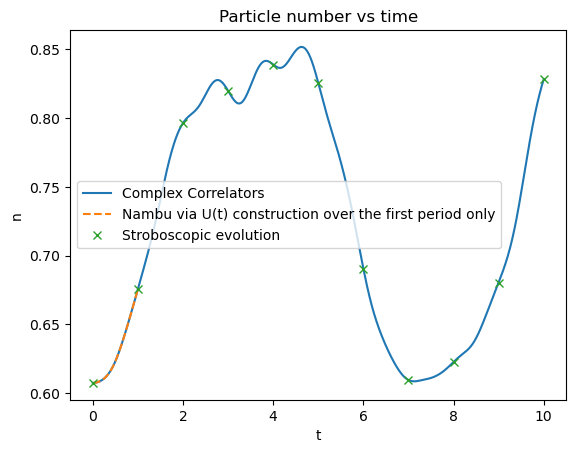

Unitarity error at t=100.0: 3.55e-13
Compare n=1, Corr
3.710982342805582
3.7109823428033346
Compare n=1, Dag
0.8388692463750962
0.838869246375752
Compare final time sum over occupations elements
3.1792143438125966
3.179214343800196
Comparison of c^+c component 1.9257314992344906e-11
Comparison of c^+c+ component 1.3162816246706593e-11
[[-0.0e+00-0.0e+00j  8.0e-13-2.0e-13j -4.4e-12-2.2e-12j]
 [-8.0e-13+2.0e-13j -0.0e+00+0.0e+00j  8.0e-13-2.0e-13j]
 [ 4.4e-12+2.2e-12j -8.0e-13+2.0e-13j  0.0e+00+0.0e+00j]]


In [133]:
Corr_mat_list = np.asarray(Corr_mat_list)
Dag_mat_list = np.asarray(Dag_mat_list)
Nambu_Corr_nT = copy.copy(Nambu_nT[:, sites:, sites:])
Nambu_Dag_nT = copy.copy(- Nambu_nT[:,0:sites,sites:])

plt.plot(dt * np.arange(0,np.size(Corr_mat_list,0)),Corr_mat_list[:, 0, 0],"-",label = "Complex Correlators")

plt.plot(dt * np.arange(0,np.size(Nambu_T_mat,0)),Nambu_T_mat[:, sites, sites],"--",label = "Nambu via U(t) construction over the first period only")

plt.plot(h1_period * np.arange(0,stroboscopic_times+1), Nambu_nT[:,sites,sites], "x", label = "Stroboscopic evolution") # check the value of the correlation matrix at the end of one period

#ED_particle = 0.5 + np.load('/Users/samuelbegg/Desktop/Dump/magsites.npy')
#plt.plot(0.1 * np.arange(0,np.size(ED_particle,1)),ED_particle[0,:],"--r",label = "ED")
plt.legend()
plt.ylabel("n")
plt.xlabel("t")
plt.title("Particle number vs time")
plt.show()


# check unitary error at time T (1 period), i.e. U^T U will deviate from Identity by a small amount
U = sol.y[:,-1].reshape((2*sites, 2*sites))
unitarity_error = np.linalg.norm(U.conj().T @ U - np.eye(2*sites))
print(f"Unitarity error at t={10000*dt}: {unitarity_error:.2e}")

# compare at n = 1 (first stroboscopic time)
print("Compare n=1, Corr")
print(np.sum(np.abs(Nambu_nT[1,sites:,sites:])))
print(np.sum(np.abs(Corr_mat_list[oneperiod_steps, :, :])))

print("Compare n=1, Dag")
print(np.sum(np.abs(Nambu_nT[1,0:sites,sites:])))
print(np.sum(np.abs(Dag_mat_list[oneperiod_steps, :, :])))

# check error at final time
print("Compare final time sum over occupations elements")
print(np.sum(np.abs(Nambu_nT[-1,sites:,sites:])))
print(np.sum(np.abs(Corr_mat_list[-1, :, :])))
#print(np.sum(ED_particle[:,-1]))

# Compare the full matrices from both fermionic approaches
print("Comparison of c^+c component", np.sum(np.abs(Nambu_nT[-1,sites:,sites:] - Corr_mat_list[-1, :, :])))
print("Comparison of c^+c+ component", np.sum(np.abs(Nambu_nT[-1,sites:,0:sites] - Dag_mat_list[-1, :, :])))
# Compare)


print(np.round(Nambu_nT[-1,sites:,0:sites] - Dag_mat_list[-1, :, :],13))


plot X_j X_{j+1}

(11, 3, 3)
(11, 3, 3)


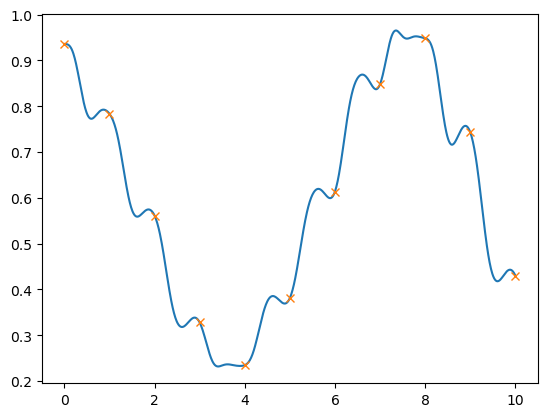

In [134]:
jj = 0
# results for direct integration
obs = copy.copy(Corr_mat_list)
Dag_obs = copy.copy(Dag_mat_list)

print(np.shape(Nambu_Corr_nT))

print(np.shape(Nambu_Dag_nT))


sigma_Xsq_Direct = (obs[:, jj, jj+1] + np.conj(obs[:, jj, jj+1]) +  Dag_obs[:, jj, jj+1] + np.conj(Dag_obs[:, jj, jj+1]))

sigma_Xsq_Nambu = Nambu_Corr_nT[:, jj, jj+1] + np.conj(Nambu_Corr_nT[:, jj, jj+1]) +  Nambu_Dag_nT[:, jj, jj+1] + np.conj(Nambu_Dag_nT[:, jj, jj+1])
#<c^+j c_j> + <c^+{j+1} c_j> + <c^+j c^+_{j+1}> + <c_{j+1} c_j> 


plt.plot(dt * np.arange(0,np.size(Corr_mat_list,0)), sigma_Xsq_Direct, label = "Direct integration")
plt.plot(h1_period * np.arange(0,stroboscopic_times+1), sigma_Xsq_Nambu, "x",label = "Nambu integration")
plt.show()



Test disordered Hamiltonian generation

In [135]:
Jvec = J * rand.random(sites)
hvec = 0 * rand.random(sites)

Ham_dis = Hnambu_disorder(Jvec,  gamma, hvec, sites)
print("Disordered Hamiltonian", np.round(Ham_dis,3).real)

Ham = Hnambu(J, gamma, 0, sites)
print("Clean Hamiltonian", np.round(Ham,3).real)

print(Jvec)

Disordered Hamiltonian [[-0.    -0.252 -0.119  0.    -0.202  0.095]
 [-0.252 -0.    -0.41   0.202  0.    -0.328]
 [-0.119 -0.41  -0.    -0.095  0.328  0.   ]
 [ 0.     0.328 -0.202  0.     0.252  0.119]
 [-0.328  0.     0.095  0.252  0.     0.41 ]
 [ 0.202 -0.095  0.     0.119  0.41   0.   ]]
Clean Hamiltonian [[ 0.  -0.5 -0.5  0.  -0.4  0.4]
 [-0.5  0.  -0.5  0.4  0.  -0.4]
 [-0.5 -0.5  0.  -0.4  0.4  0. ]
 [ 0.   0.4 -0.4  0.   0.5  0.5]
 [-0.4  0.   0.4  0.5  0.   0.5]
 [ 0.4 -0.4  0.   0.5  0.5  0. ]]
[0.50432085 0.82013265 0.23848475]
